<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/00_cora_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to apply a simple **K-nearest neighbors on Cora** dataset to understand the labels of the graph.

*NB: it is actually a slightly modified version of the KNN where we consider a k-hop neighborhood and not k neighbors*

The expectations are:
- the influence of node locality is way more significant than node features, in other words, we can label nodes just by looking at its neighbors
- we can compute the graph problem radius by plotting the accuracy w.r.t the size of the neighborhood considered

## **Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

num_test_nodes = G.test_mask.sum().item()

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from collections import Counter
from torch_geometric.utils import to_dense_adj
from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style('darkgrid')

In [4]:
dense_adj = to_dense_adj(G.edge_index).squeeze(0)

## **Building a KNN**

In [ ]:
test_acc = 0
num_test_nodes = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        for j in range(G.num_nodes):
            if A[i, j] != 0:
                neb_labels += [G.y[j].item()]
        
        # find the most occurence in the neighborhood
        count = Counter(neb_labels)
        pred = max(count, key=lambda x: d[x])
        if pred == G.y[i]: test_acc += 1

In [ ]:
test_acc / num_test_nodes

0.789

That is what I thought 🤯
A KNN with a 1-hop neighborhood performs better than most graph neural networks!!!

But we cheated a little bit 🤭. We looked at neighbors regardless of whether they are part of our training set. Let's see what happens if we just consider nodes from our training set:

In [ ]:
test_acc = 0
num_test_nodes = 0
num_no_neighbors = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        for j in range(G.num_nodes):
            if A[i, j] != 0 and G.train_mask[j]:
                neb_labels += [G.y[j].item()]
        
        # find the most occurence in the neighborhood
        if len(neb_labels) != 0:
            count = Counter(neb_labels)
            pred = max(count, key=lambda x: d[x])
            if pred == G.y[i]: test_acc += 1
        else:
            num_no_neighbors += 1

In [ ]:
print(f"Test accuracy: {test_acc / num_test_nodes}")
print(f"{num_no_neighbors}/{num_test_nodes} () testing nodes had no training nodes in their direct neighborhood")

Test accuracy: 0.169
789/1000 testing nodes had no training nodes in their direct neighborhood


Ok now this an entirely different score. Most of our testing nodes are actually around other testing nodes.

Let's try to increase the neighborhood by one:

### **Compute k-hop adjacency matrices**

In [12]:
def get_k_hop_neighborhood(k:int, adj: torch.tensor) -> list:
    """Returns the list of k-hop dense adjacency matrices
    
    Args:
        - k (int): maximum depth of neighborhood to compute
        - adj [num_nodes, num_nodes]: dense adjacency matrix
    
    :rtype: List[torch.Tensor]
    """
    
    k_hop_neb = [adj.clone()]
    pow_A = adj.clone()

    for l in tqdm(range(k-1)):
        pow_A = torch.mm(adj, pow_A)
        k_neb = torch.where(
            torch.where(pow_A > 0, 1, 0) - sum(k_hop_neb) > 0,
            1,
            0
        )
        k_hop_neb.append(k_neb)
    
    return k_hop_neb

In [13]:
all_adj = get_k_hop_neighborhood(20, dense_adj)

  0%|          | 0/19 [00:00<?, ?it/s]

### **Finding the right depth**

Now let's put all of this into a function and run it over several neighborhood sizes to see how our performance evolves

In [ ]:
def run(k: int):
    test_acc = 0
    num_test_nodes = 0
    num_no_neighbors = 0
    k_neb = sum(get_k_hop_neighborhood(k, A+torch.eye(A.size(0))))

    for i in range(G.num_nodes):
        if G.test_mask[i]:
            num_test_nodes += 1
            neb_labels = []
            # count all the labels from its neighbors
            neb_labels = [G.y[j] for j in range(A.size(0)) if G.train_mask[j] and k_neb[i,j] == 1]
            
            # find the most occurence in the neighborhood
            if len(neb_labels) != 0:
                count = Counter(neb_labels)
                pred = max(count, key=lambda x: count[x])
                if pred == G.y[i]: test_acc += 1
            else:
                num_no_neighbors += 1
    
    return test_acc/num_test_nodes, num_no_neighbors

In [ ]:
all_test_acc, all_num_no_neb = [], []
for k in range(1, 7):
    test_acc, num_no_neb = run(k)
    all_test_acc.append(test_acc)
    all_num_no_neb.append(num_no_neb)
    
    print(f"k: {k} | test_acc: {test_acc} | num_no_neb: {num_no_neb}")

k: 1 | test_acc: 0.169 | num_no_neb: 789
k: 2 | test_acc: 0.413 | num_no_neb: 382
k: 3 | test_acc: 0.439 | num_no_neb: 186
k: 4 | test_acc: 0.401 | num_no_neb: 101
k: 5 | test_acc: 0.361 | num_no_neb: 76
k: 6 | test_acc: 0.339 | num_no_neb: 66


In [ ]:
all_num_no_neb = list(map(lambda x: x/1000, all_num_no_neb))

[Text(0.5, 1.0, 'KNN on Cora')]

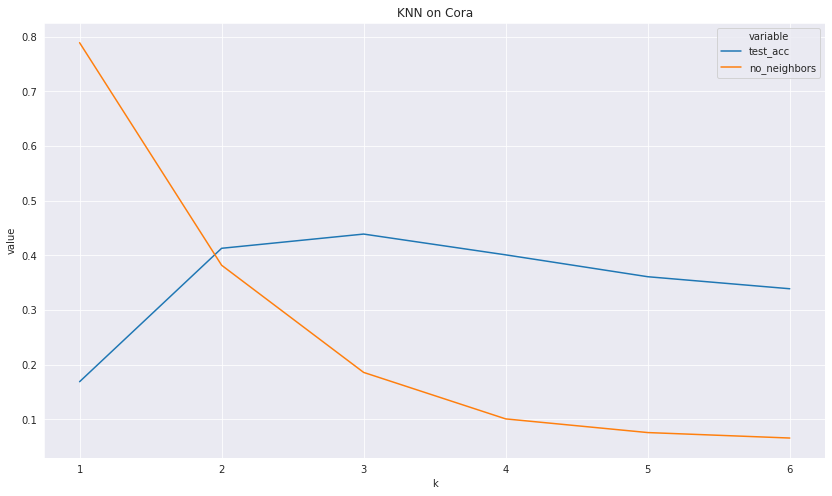

In [ ]:
plt.figure(figsize=(14, 8))


data = pd.DataFrame({
    'k': range(1, 7),
    'test_acc': all_test_acc,
    'no_neighbors': all_num_no_neb
})

sns.lineplot(x='k', y='value', hue='variable', data=pd.melt(data, ['k'])).set(title="KNN on Cora")

Even with a depth of 3 we keep getting better results (the vanilla GCN lose its accuracy after 2 layers).

### **More hyperparameters**

Now let's try something different. We will run the KNN several time so that after labelling the nodes that we can label, we will have new neighbors to consider.
So we now have two hyperparameters:
- k: the size of the neighborhood
- n: the number of time we want to run the KNN

In [ ]:
def run_and_label(labels:list, neb:torch.tensor):
    """Run KNN on test set with already labelled nodes and returns the new 
    labels, updated accuracy and the number of nodes from the test set that do not have neighbors from the training set.

    Args:
        - labels [num_nodes]: all the labels where unlabelled nodes are set to -1
        - neb [num_nodes, num_nodes]: neighbors to consider (can be adjacency matrix or k-hop neighborhood)
    """

    test_acc, num_no_neighbors = 0, 0
    new_labels = labels.clone()

    for i in range(G.num_nodes):
        if G.test_mask[i] and labels[i] == -1: # to avoid labelling nodes already labelled
            neb_labels = labels[neb[i] * (labels!=-1) == 1] # nodes from the training set and labelled nodes only
            
            # find the most occurence in the neighborhood
            if len(neb_labels) != 0:
                count = Counter(neb_labels)
                pred = max(count, key=lambda x: count[x])
                new_labels[i] = pred.item()
                if pred == G.y[i]: test_acc += 1
            else:
                num_no_neighbors += 1
    
    return new_labels, test_acc/num_test_nodes, num_no_neighbors

In [ ]:
k_neb = get_k_hop_neighborhood(k=6, adj=A)

results = pd.DataFrame(columns=['k', 'n', 'test_acc', 'no_neb'])
id = 0

for k in range(1, 7):
    labels = torch.where(G.train_mask, G.y, -1)
    for n in range(1, 7):
        labels, test_acc, no_neb = run_and_label(labels, neb=k_neb[k-1])
        results.loc[id] = {'k':k, 'n':n, 'test_acc': test_acc, 'no_neb': no_neb}
        id += 1

        print(f"k: [{k}/3] | n: [{n}/3] | acc: {test_acc} | no_neighbors: {no_neb}")

k: [1/3] | n: [1/3] | acc: 0.169 | no_neighbors: 789
k: [1/3] | n: [2/3] | acc: 0.137 | no_neighbors: 589
k: [1/3] | n: [3/3] | acc: 0.059 | no_neighbors: 500
k: [1/3] | n: [4/3] | acc: 0.029 | no_neighbors: 453
k: [1/3] | n: [5/3] | acc: 0.01 | no_neighbors: 429
k: [1/3] | n: [6/3] | acc: 0.004 | no_neighbors: 422
k: [2/3] | n: [1/3] | acc: 0.34 | no_neighbors: 459
k: [2/3] | n: [2/3] | acc: 0.126 | no_neighbors: 186
k: [2/3] | n: [3/3] | acc: 0.022 | no_neighbors: 139
k: [2/3] | n: [4/3] | acc: 0.002 | no_neighbors: 136
k: [2/3] | n: [5/3] | acc: 0.0 | no_neighbors: 136
k: [2/3] | n: [6/3] | acc: 0.0 | no_neighbors: 136
k: [3/3] | n: [1/3] | acc: 0.336 | no_neighbors: 247
k: [3/3] | n: [2/3] | acc: 0.075 | no_neighbors: 95
k: [3/3] | n: [3/3] | acc: 0.004 | no_neighbors: 91
k: [3/3] | n: [4/3] | acc: 0.0 | no_neighbors: 91
k: [3/3] | n: [5/3] | acc: 0.0 | no_neighbors: 91
k: [3/3] | n: [6/3] | acc: 0.0 | no_neighbors: 91
k: [4/3] | n: [1/3] | acc: 0.288 | no_neighbors: 135
k: [4/3] |

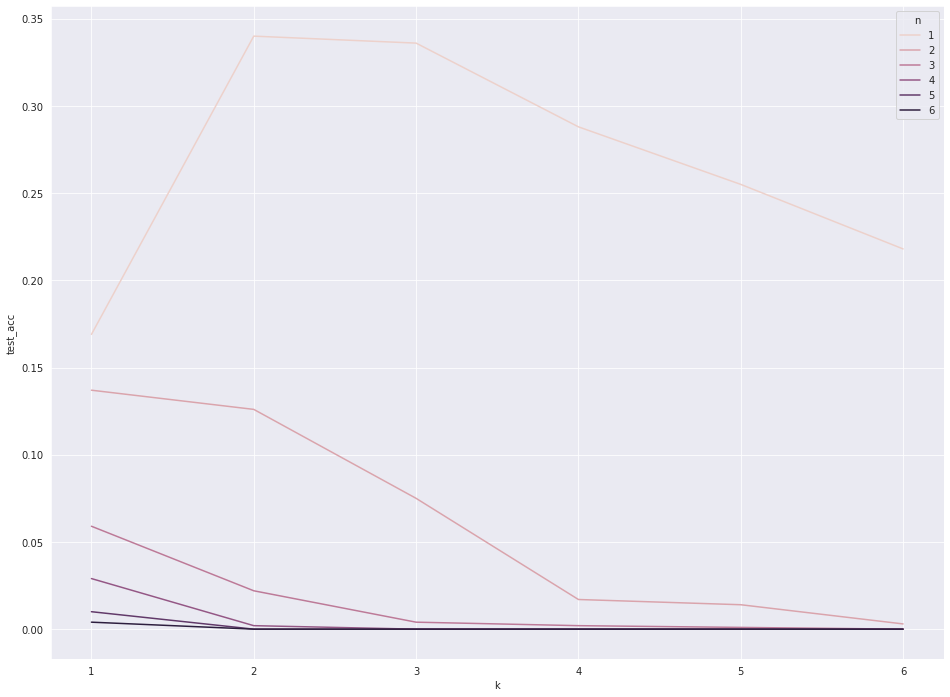

In [ ]:
plt.figure(figsize=(16, 12))

sns.lineplot(x='k', y='test_acc', data=results, hue='n')

[Text(0.5, 1.0, 'Testing accuracy of the KNN with different neighborhood depth')]

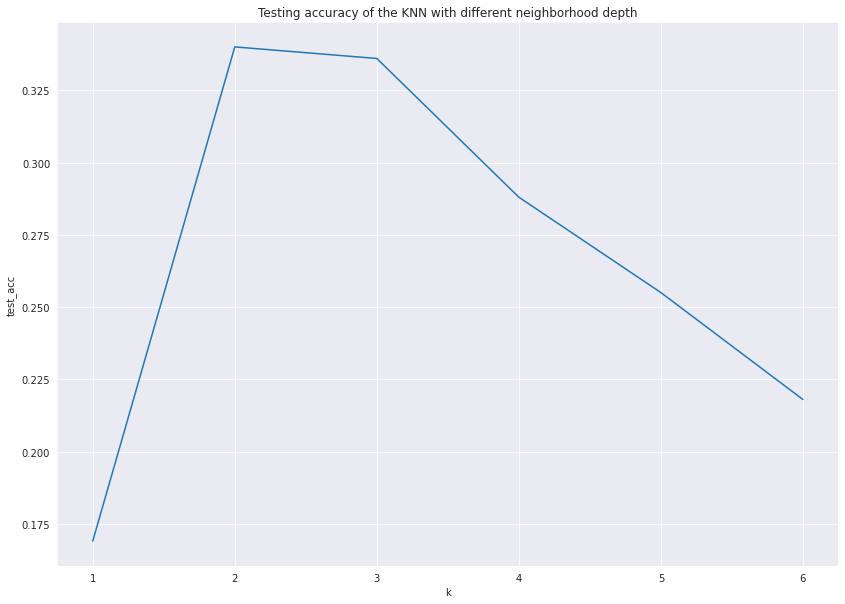

In [ ]:
plt.figure(figsize=(14, 10))

sns.lineplot(x=results['k'], y=results[results['n']==1]['test_acc'], data=results).set(title='Testing accuracy of the KNN with different neighborhood depth')

## **Measuring uninformative receptive fields**

$$
information\_quality(v) = \frac{ \left| \{ u \in \mathcal N(v) | c(u) = c(v) \} \right| }{  \left| \mathcal N(v) \right| }
\;,
\;\; \forall v \in \cal V
$$

In [ ]:
def information_ratio(i:int, neb:torch.tensor, mask=None):
    """
    Args:
        - i: index of a node
        - neb [num_nodes, num_nodes]: neighbors to consider (can be the adjacency matrix or k-hop neighborhood)
        - mask [num_nodes]: "train", "test" or "val" to consider only these specific neighbors
    """
    if mask == None:
        mask = torch.ones(G.num_nodes)

    labels = G.y[neb[i] * mask == 1]
    # labels = torch.tensor([G.y[j] for j in range(G.num_nodes) if neb[i,j] == 1 and mask[j]])

    if len(labels) == 0: return 0
    
    return (labels == G.y[i]).sum().item() / len(labels)

In [ ]:
torch.tensor([information_ratio(i, A) for i in range(G.num_nodes)]).mean()

tensor(0.8252)

In [ ]:
# get 1 to 10-hop neighborhoods
nebs = get_k_hop_neighborhood(10, A)

In [ ]:
info_ratio = pd.DataFrame(columns=['k', 'train_ratio', 'hop_ratio', 'all_neb'])

In [ ]:
test_idx = [i for i in range(G.num_nodes) if G.test_mask[i]]
neb = torch.zeros(G.num_nodes, G.num_nodes)

for k in range(1, 10):
    neb = neb + nebs[k-1]
    
    train_ratio = torch.tensor(
        [information_ratio(i, neb, mask=G.train_mask) for i in test_idx]
    ).mean().item()
    hop_ratio = torch.tensor(
        [information_ratio(i, nebs[k-1], mask=G.train_mask) for i in test_idx]
    ).mean().item()
    all_neb_ratio = torch.tensor(
        [information_ratio(i, nebs[k-1]) for i in test_idx]
    ).mean().item() 
    
    info_ratio.loc[k-1] = {'k':k, 'train_ratio': train_ratio, 'hop_ratio': hop_ratio, 'all_neb': all_neb_ratio}

    print(f"k: {k} | train_ratio: {train_ratio} | hop-ratio: {hop_ratio} | all neighbors: {all_neb_ratio}")

k: 1 | train_ratio: 0.16891667246818542 | hop-ratio: 0.16891667246818542 | all neighbors: 0.816875696182251
k: 2 | train_ratio: 0.45707565546035767 | hop-ratio: 0.3880768418312073 | all neighbors: 0.7619004249572754
k: 3 | train_ratio: 0.4762896001338959 | hop-ratio: 0.37553074955940247 | all neighbors: 0.5438345074653625
k: 4 | train_ratio: 0.39577797055244446 | hop-ratio: 0.2910778820514679 | all neighbors: 0.3777962625026703
k: 5 | train_ratio: 0.29598456621170044 | hop-ratio: 0.1808316707611084 | all neighbors: 0.24327242374420166
k: 6 | train_ratio: 0.23052231967449188 | hop-ratio: 0.11646512895822525 | all neighbors: 0.16547228395938873
k: 7 | train_ratio: 0.1963481456041336 | hop-ratio: 0.08987057954072952 | all neighbors: 0.12800486385822296
k: 8 | train_ratio: 0.17813144624233246 | hop-ratio: 0.06578488647937775 | all neighbors: 0.11155708879232407
k: 9 | train_ratio: 0.16906602680683136 | hop-ratio: 0.04480306804180145 | all neighbors: 0.10523762553930283


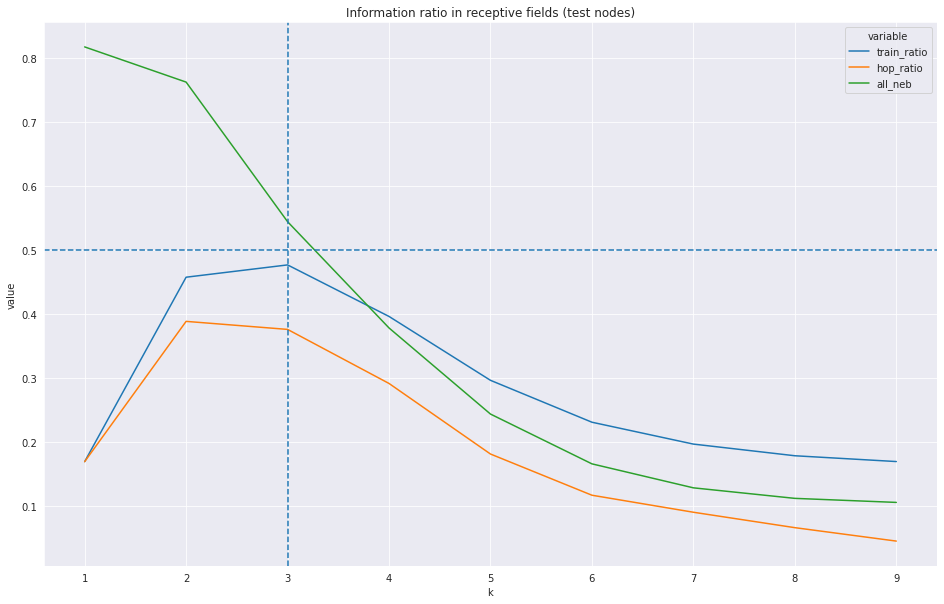

In [ ]:
plt.figure(figsize=(16, 10))
sns.lineplot(x='k', y='value', hue='variable', data=pd.melt(info_ratio.astype('float64'), ['k'])).set(title="Information ratio in receptive fields (test nodes)")
plt.axvline(x=3, linestyle='--')
plt.axhline(y=.5, linestyle='--')

_info: the target nodes considered are from the test set, and only the nodes from the training set were considered in the information ratio_

We should also note that in smaller neighborhoods, most nodes from the test set do not have any neighbors from the training set. This explains why the ratio is so low at the beginning (and not because direct neighbors are from different classes).

## **Information quality by Feature Correlation**

### **Feature - Label correlation**

For each node $v$ and each feature $j$:
$$
\sum_v \sum_{u \in \mathcal N^K(v)} (X_{u}[j] - l_v)^2
$$

- What does the difference between a feature and the label should mean anyway?
<br/>
- What should we expect from these values?
<br/>
- W.r.t the information quality of the neighborhood?

I don't think this is what we are looking for, because we are comparing two different things: node features and node labels which have nothing in common and are not supposed to follow the same distribution.

In [6]:
adj_self_loops = dense_adj + torch.eye(dense_adj.size(0))

In [ ]:
all_adj = get_k_hop_neighborhood(20, adj_self_loops)

In [ ]:
i = 0 # target node
j = 0 # feature considered

torch.tensor([
    torch.tensor([
        ((G.x[all_adj[0][i] == 1][:,j] - G.y[i])**2).sum() for i in range(G.num_nodes)
    ]).sum()
    for j in range(G.num_features)
])

tensor([139750., 139398., 138806.,  ..., 140087., 138373., 139830.])

In [ ]:
j = 0

(G.x[all_adj[0][i] == 1][j] - G.y[i]) **2

In [ ]:
def correlation(i:int, edges:torch.Tensor):
    """
    Args:
        - i: target node
        - edges [num_nodes, num_nodes]: dense matrix of edges
    """
    return ((G.x[edges[i] == 1] - G.y[i])**2).sum(0)

In [ ]:
correlations = [correlation(i, k=1) for i in range(G.num_nodes)]

In [ ]:
correlations = torch.tensor(list(map(lambda x: x.numpy(), correlations)))

In [ ]:
pd.DataFrame(correlations.numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,16.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,31.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,31.0,36.0
1,64.0,64.0,64.0,64.0,57.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,36.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,...,64.0,64.0,64.0,64.0,57.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,57.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0
2,96.0,96.0,96.0,96.0,96.0,96.0,89.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,68.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,89.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,89.0,96.0,96.0,96.0,...,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,89.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54.0,49.0,54.0,49.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,...,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,18.0,18.0,18.0,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
2704,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,8.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
2705,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
2706,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,25.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,4

In [ ]:
df = pd.DataFrame(correlations.numpy())

In [ ]:
df.iloc[:,0:30]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,16.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
1,64.0,64.0,64.0,64.0,57.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,36.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0
2,96.0,96.0,96.0,96.0,96.0,96.0,89.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,68.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,89.0,96.0,96.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54.0,49.0,54.0,49.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,18.0,18.0,18.0,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
2704,18.0,18.0,13.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
2705,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
2706,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,25.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0


In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.00000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,...,2708.000000,2708.000000,2708.000000,2708.000000,2708.00000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,51.606350,51.476368,51.257755,51.342319,49.562038,51.695717,51.574226,51.694241,51.444241,51.741138,51.686115,51.688332,51.489662,51.619644,51.685009,51.692394,51.577179,51.686115,51.550961,47.059822,51.740398,51.729691,51.741138,51.581612,51.711964,51.035080,51.207165,51.469349,51.693130,51.759602,51.60746,51.722305,51.708271,51.704208,51.652142,51.596752,51.705318,51.715286,51.452732,50.424297,...,50.840103,51.679100,51.504799,51.713810,50.16396,51.728580,51.675407,51.729691,51.700886,51.726734,51.685009,51.730427,51.740398,51.640324,51.714550,51.717873,51.604504,51.678360,51.674667,51.328655,51.273266,51.328655,51.713810,51.702732,51.672821,51.289883,51.687962,51.706795,51.741508,51.336040,50.873337,51.249630,51.265511,50.912113,51.529171,51.741508,51.442024,51.730797,51.097858,51.635895
std,68.378014,68.211952,68.055496,67.961525,65.949036,68.457207,68.500343,68.516724,68.277092,68.568016,68.499626,68.545403,68.221916,68.514603,68.478523,68.505577,68.472183,68.543259,68.353531,66.461945,68.550949,68.500755,68.551895,68.438545,68.477875,67.543663,67.923798,68.281441,68.463837,68.560913,68.30220,68.525909,68.545746,68.535645,68.449310,68.305527,68.512512,68.507141,68.382492,67.142944,...,67.366470,68.507568,68.298225,68.554199,66.34063,68.541168,68.513062,68.525032,68.522369,68.580383,68.506187,68.471947,68.528587,68.514557,68.512939,68.495567,68.452293,68.509491,68.506920,68.245911,67.896164,68.245911,68.552147,68.508507,68.514648,68.059555,68.513794,68.505257,68.561050,68.169304,67.655586,68.213707,67.984276,67.399628,68.294861,68.550545,68.243843,68.532570,67.525307,68.505104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,9.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000

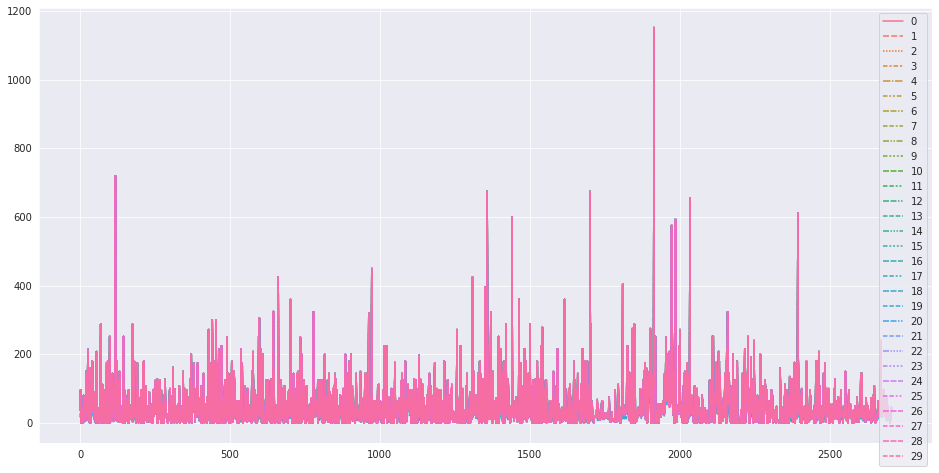

In [ ]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=df.iloc[:,0:30])

Values for different features $j$ seem quite similar, as well as across nodes, so it makes sense to consider the mean and monitor correlation over neighborhood depth:

In [ ]:
all_corr = []

for k in tqdm(range(1,11)):
    corr = np.mean([correlation(i, sum(all_adj[:k])).mean().item() for i in range(G.num_nodes)])
    all_corr += [corr]
    print(f"Depth: {k} | Correlation: {corr}")

In [ ]:
plt.figure(figsize=(12, 10))

sns.lineplot(x=range(1,11), y=all_corr).set(xlabel="Neighborhood depth", ylabel="Correlation")

### **Correlation with  barycenter representation of labels**

- step 1: compute the average observation of each label
- step 2: compute the correlation between the node feature of the neighbors and the average observation associated with the target node's label

$$
\bar{X}_j = mean( \left\{ X_v | c(v) = j  \right\} )
$$

<br/>

<center>
$c(v) = j$
<br/>
$mean(\left\{ |corr(X_u, \bar{X}_j)|, \; \forall u \in \cal N(v) \right\})$
</center>

In [7]:
# Dictionary of nodes by label
obs = {}

for i in range(G.num_nodes):
    if obs.get(G.y[i].item()):
        obs[G.y[i].item()] += [G.x[i]]
    else:
        obs[G.y[i].item()] = [G.x[i]]

[Text(0.5, 1.0, 'Label distribution')]

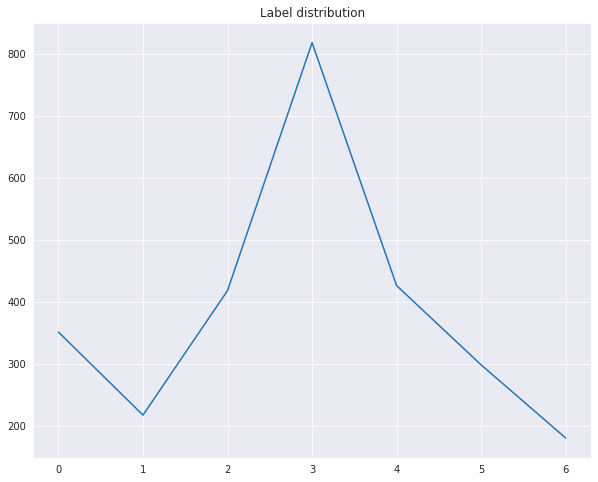

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=range(7), y=[len(obs[c]) for c in range(7)]).set(title="Label distribution")

In [8]:
avg_obs = [ sum(obs[c]) / len(obs[c]) for c in range(7) ]
# convert to torch tensor
avg_obs = torch.tensor(list(map(lambda x: x.numpy(), avg_obs)))
avg_obs.shape # [num_label, num_features]

torch.Size([7, 1433])

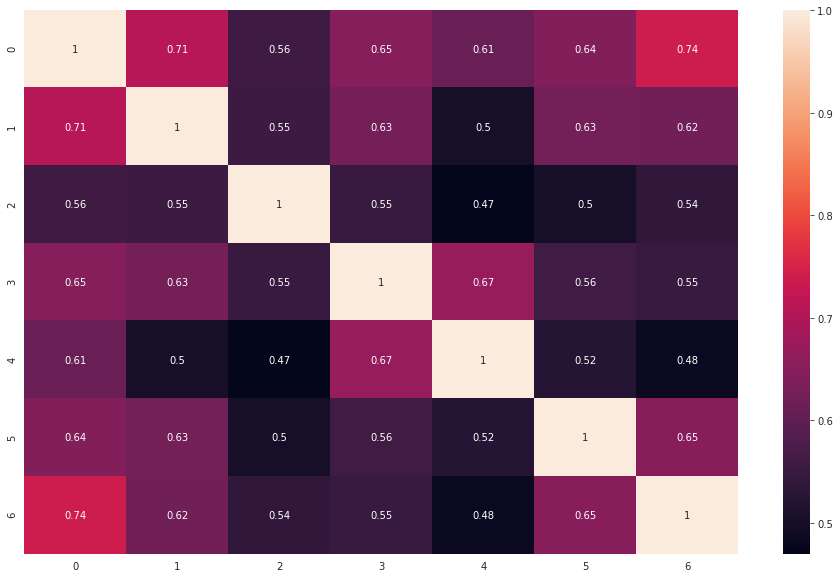

In [9]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.corrcoef(avg_obs.numpy()), annot=True)

This might not work as the average members are already quite similar so the correlation with the neighbors will not be as expressive as I thought they would.

In [118]:
def get_label_barycenters(X:torch.Tensor, y:torch.Tensor):
    """
    Args:
        - X [num_nodes, num_features]
        - y [num_nodes]
    """
    
    # group nodes by label
    obs = {}
    for i in range(X.size(0)):
        if obs.get(y[i].item()):
            obs[y[i].item()] += [X[i]]
        else:
            obs[y[i].item()] = [X[i]]

    avg_obs = [ sum(obs[c]) / len(obs[c]) for c in range(7) ]
    
    # convert to torch tensor
    return torch.tensor(list(map(lambda x: x.numpy(), avg_obs)))

$$mean(\left\{ |corr(X_u, \bar{X}_j)|, \; \forall u \in \cal N_k(v) \right\})$$


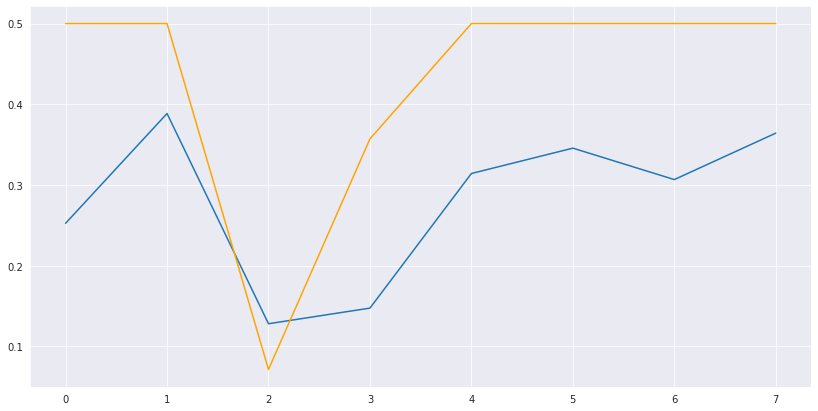

In [85]:
i = 5 # node index
k = 2

plt.figure(figsize=(14, 7))

plt.plot(np.corrcoef(
    x=G.x[ sum(all_adj[:k])[i] == 1 ].numpy(), # features of the (direct) neighbors
    y=avg_obs[G.y[i].item()].numpy()
)[:-1, -1])

plt.plot(.5-np.abs(G.y[sum(all_adj[:k])[i] == 1].numpy() - G.y[i].numpy())/7, c='orange')

In [143]:
def feature_correlation(all_adj, X, barycenters, k):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - all_adj: list of k-hop adjacency dense matrices [num_nodes, num_nodes]
        - X: [num_nodes, num_features] features
        - barycenters: [num_classes, num_features]
        - k (int): depth of the neighborhood

    :rtype: list - [num_nodes]
    """

    return [
            np.mean(np.corrcoef(
                x=X[ sum(all_adj[:k])[i] == 1 ].numpy(),
                # x=X[ all_adj[k-1][i] == 1 ].numpy(),
                y=barycenters[G.y[i].item()].numpy()
            )[:-1, -1].abs()) if (all_adj[k-1][i] == 1).sum() > 0 else 0
            for i in range(X.size(0))]

[Text(0.5, 1.0, 'Correlations (direct neighbors)')]

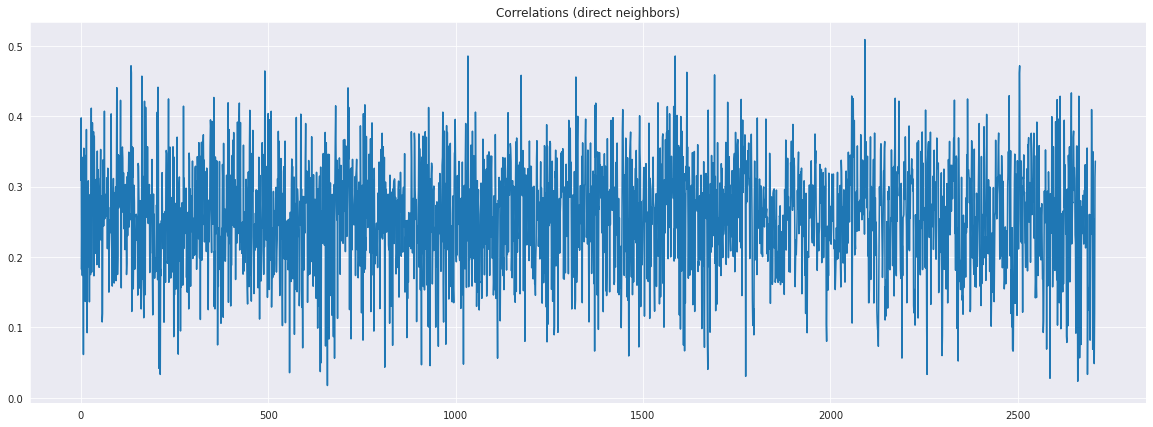

In [91]:
direct_correlations = feature_correlation(all_adj, G.x, avg_obs, 1)

plt.figure(figsize=(20,7))
sns.lineplot(x=range(G.num_nodes), y=direct_correlations).set(title="Correlations (direct neighbors)")

### **Looking at how feature correlation over depth**

In [144]:
k_hop_correlations = [np.mean(feature_correlation(all_adj, G.x, avg_obs, k=k)) for k in tqdm(range(1, 21))]

  0%|          | 0/20 [00:00<?, ?it/s]

[Text(0, 0.5, 'Correlation'), Text(0.5, 0, 'Neighborhood depth')]

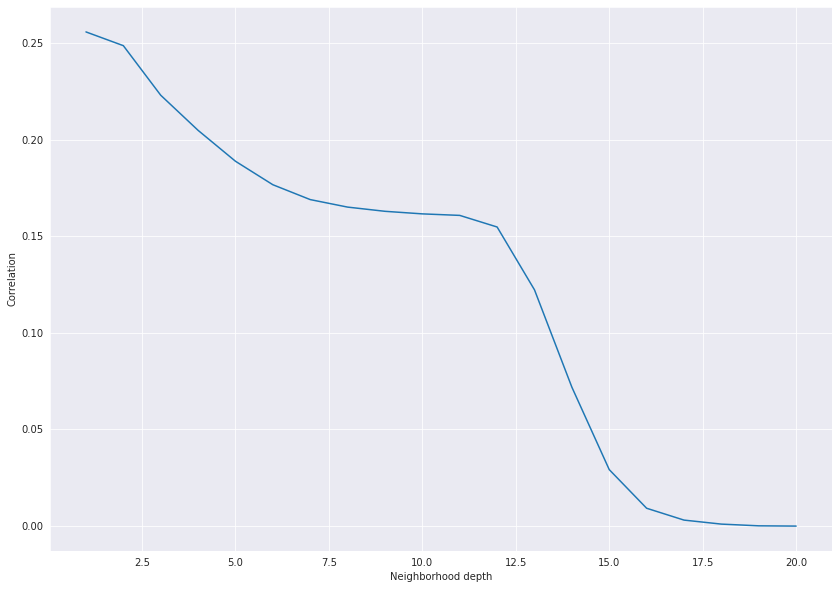

In [145]:
plt.figure(figsize=(14, 10))

sns.lineplot(x=range(1, 21), y=k_hop_correlations).set(xlabel="Neighborhood depth", ylabel="Correlation")

On k-hop neighbors only (not neighborhood!)

In [141]:
k_hop_correlations = [np.mean(feature_correlation(all_adj, G.x, avg_obs, k=k)) for k in tqdm(range(1, 21))]

  0%|          | 0/20 [00:00<?, ?it/s]

[Text(0, 0.5, 'Correlation'), Text(0.5, 0, 'Neighborhood depth')]

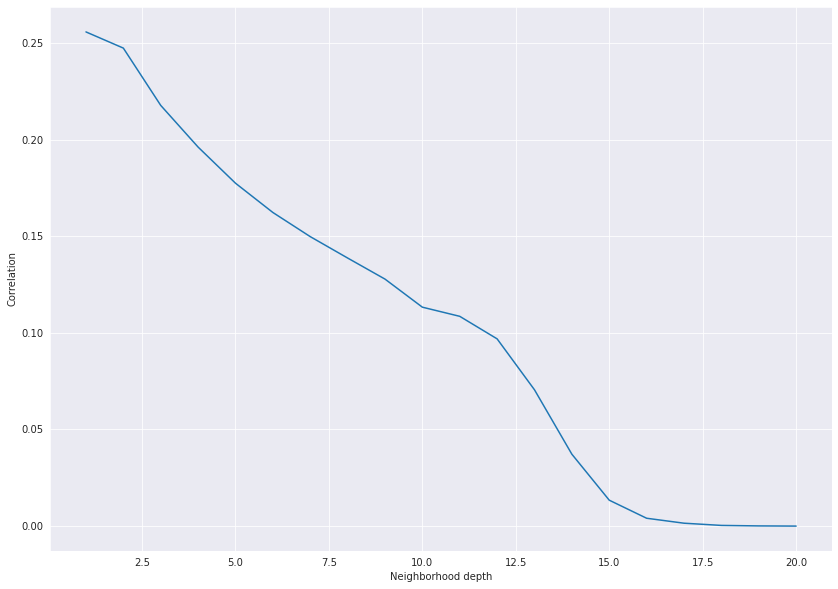

In [142]:
plt.figure(figsize=(14, 10))
sns.lineplot(x=range(1, 21), y=k_hop_correlations).set(xlabel="Neighborhood depth", ylabel="Correlation")

Why do we have such a curve?!

## **Correlation on scaled features**

In [104]:
def scale_features(X: torch.Tensor):
    # TODO: compute means and std
    m = torch.mean(X, dim=0)
    s = torch.std(X, dim=0)    
    # TODO: scale features
    return (X - m)/ s

In [125]:
X_scaled.shape

torch.Size([2708, 1433])

In [119]:
X_scaled = scale_features(G.x)
np.corrcoef(
    x=X_scaled[ sum(all_adj[:k])[i] == 1 ].numpy(),
    y=get_label_barycenters(X_scaled, G.y)[G.y[i].item()].numpy()
)[:-1, -1]

array([nan, nan, nan, nan, nan, nan, nan, nan])

## **Can we represent labels by the average of observations with that label?**

Let's verify the significance of:
$$
corr(X_v, \bar X_{c(v)} ) > corr(X_v, X_{l \neq c(v)})
$$

In [ ]:
i = 0
j = 0

[np.corrcoef(x=G.x[i].numpy(), y=avg_obs[j].numpy())[0,1] for j in range(cora_dataset.num_classes)]

[0.009514787754922711,
 0.11277047055694274,
 0.08048514986771527,
 0.3094080636986475,
 0.08810259648024217,
 0.006805818063360886,
 0.0023072425243583746]

In [ ]:
G.y[0].item()

3

This is a good start!

Node n°$0$ has a significantly higher correlation with the representation of its label (3).

In [ ]:
label_correlations = pd.DataFrame({'node':[], 'label':[], 'correlation':[], 'true_label':[]})
idx = 0

for i in range(G.num_nodes):
    for j in range(cora_dataset.num_classes):
        corr = np.corrcoef(x=G.x[i].numpy(), y=avg_obs[j].numpy())[0,1]
        
        label_correlations.loc[idx] = {'node':i, 'label':j, 'true_label':G.y[i].item(), 'correlation':corr}
        idx += 1

In [ ]:
label_correlations

,node,label,correlation,true_label
0,0.0,0.0,0.009515,3.0
1,0.0,1.0,0.112770,3.0
2,0.0,2.0,0.080485,3.0
3,0.0,3.0,0.309408,3.0
4,0.0,4.0,0.088103,3.0
...,...,...,...,...
18951,2707.0,2.0,0.059876,3.0
18952,2707.0,3.0,0.268636,3.0
18953,2707.0,4.0,0.114768,3.0
18954,2707.0,5.0,0.018767,3.0


In [ ]:
correct = 0
for i in tqdm(range(G.num_nodes)):
    true_label = G.y[i].item()
    corrs = label_correlations[label_correlations['node'] == i]
    if corrs['correlation'].max() == corrs[corrs['label'] == true_label]['correlation'].item():
        correct += 1

  0%|          | 0/2708 [00:00<?, ?it/s]

In [ ]:
print(f"{100*correct / G.num_nodes:.2f}% of nodes are more correlated with the representation of the true label")

71.71% of nodes are more correlated with the representation of the true label


This is not ideal, plus it does not tell us anything about the significance of the result.

*I am not even sure that a significance test is needed with such a low value!*

In [ ]:
label_correlations.query('node == 0')['correlation'].tolist()

[0.009514787754922711,
 0.11277047055694274,
 0.08048514986771527,
 0.3094080636986475,
 0.08810259648024217,
 0.006805818063360886,
 0.0023072425243583746]

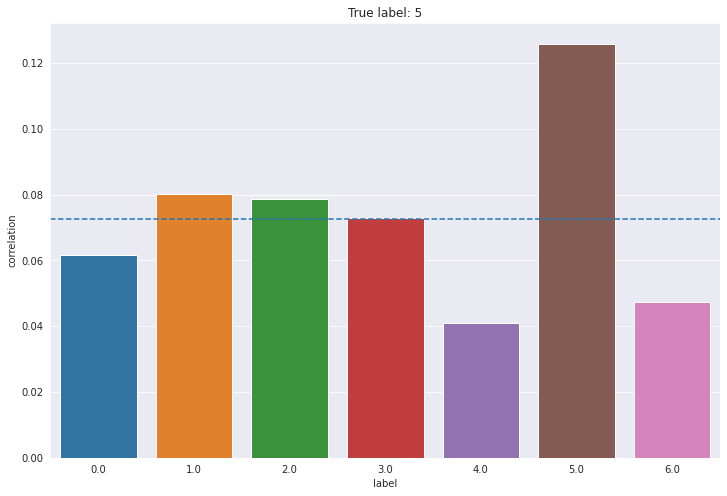

In [ ]:
plt.figure(figsize=(12, 8))

i = 20

sns.barplot(x="label", y="correlation", data=label_correlations.query(f"node == {i}")).set(title=f"True label: {G.y[i]}")
plt.axhline(y=label_correlations.query(f"node == {i}")['correlation'].mean(), linestyle='--')

##### **TODO**: Find a significance test

*H:* $corr(X_v, \bar X_{c(v)} ) > corr(X_v, X_{l \neq c(v)})$

Maybe a Wald test?

# **END**